In [2]:
from skimage import filters
import pickle
import os
from metadata import Metadata
import time
from skimage.morphology import selem
from skimage.morphology import dilation
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
import itertools as it
from skimage.feature import peak_local_max
from skimage.measure import label,regionprops
from skimage.morphology import watershed


#This function loads images, substract background and append a list of selected images to df
def pfunc_zstk_filt(Input):
    pname = Input['pname']
    threshold = Input['threshold']
    md_local = Input['md_local']
    acq = Input['acq']
    chan = Input['chan']
    blur = Input['blur']
    rel_thresh = Input['rel_thresh']
    npixels_thresh = Input['npixels_thresh']
    pos_path = Input['pos_path']
    if os.path.exists(os.path.join(pos_path,'df.pkl')):
        return
    print(pname, '\n')
    disk = selem.disk(2)
    stk = md_local.stkread(Position=pname, Channel=chan, acq=acq)#loading images
    
    #check if the type of stk is dictionary, print the position, channel, and aquisition
    if type(stk)==dict:
        print('stk empty')
        print('Pos: ',pname)
        print('Channel: ',chan)
        print('Acq: ',acq)
        return
    
   # background subtraction
    fstk = diffGauss(stk, blur)
    
    # returns the coordinates of local peaks (maxima) in an image
    peaks_coords = peak_local_max(fstk, threshold_abs=threshold,
                                  min_distance=3)
    peaks = peak_local_max(fstk, threshold_abs=threshold,
                           min_distance=3, indices=False)
    dfs = []
 
    for z in set(peaks_coords[:, 2]):
        img = fstk[:,:,z]
        labels = label(peaks[:, :, z])
        #watershed is used for image segmentation
        spot_labels = watershed(gaussian_filter(img, 1.2)*-1, labels, mask=dilation(peaks[:,:, z], selem=disk))
        spots = regionprops(spot_labels, img)#Measure properties of labeled image regions
        npixels = np.array([p.area for p in spots])#creates an array
        spot_means = np.array([p.mean_intensity for p in spots])
        spot_max = [p.max_intensity for p in spots]
        centroids = np.array([p.weighted_centroid for p in spots])
    #     rna = np.where((spot_means>threshold)&(npixels>=npixels_thresh))[0]
        rna = np.arange(len(spots))
        rna_coords = centroids[rna]
        spot_values = []
        for p in spots:
            vals = [img[y, x] for y, x in p.coords]
            spot_values.append(vals)#append coordinates to spot_value

        df = pd.DataFrame(np.stack([spot_means[rna], rna_coords[:,0],
                                    rna_coords[:, 1],
                                    tuple(it.repeat(z, len(spot_means[rna])))], axis=1),
                          columns = ['val', 'y', 'x', 'z'])#Join a sequence of arrays along new axises.
        df['pixel_values'] = spot_values
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    npixels = []
    ssum = []
    stdpixels = []
    for pixel_values in df.pixel_values:
        pixel_array = np.array(pixel_values)
        npixels.append(len(pixel_array[pixel_array>npixels_thresh]))
        ssum.append(np.sum(pixel_values))
        stdpixels.append(np.std(pixel_values))
    df['npixels'] = npixels
    df['ssum'] = ssum
    df['stdpixels'] = stdpixels
    pickle.dump(pname,open(os.path.join(pos_path,'pname.pkl'),'wb'))
    pickle.dump(fstk.max(axis=2),open(os.path.join(pos_path,'fstk_max.pkl'),'wb'))
    pickle.dump(df,open(os.path.join(pos_path,'df.pkl'),'wb'))
    pickle.dump(spot_labels,open(os.path.join(pos_path,'spot_labels.pkl'),'wb'))

    return


# This function sets blur magnitude and substract the background
def diffGauss(stk, blur = (0.5,0.5,0.)):
    stk = stk.astype('float64')
    stk = stk.copy()
    lp = gaussian_filter(stk, blur)
    stk = stk-lp
    stk = gaussian_filter(stk, (0.25,0.25,0.25))
    np.place(stk, stk<0, 0)
    return stk.astype('int16')



In [26]:
Inputs = []
md_path = '/hybedata/Images/Michelle/FISH_Signal_Amp/IDT_[PER]_2019Aug20/[PER]_600ms_2'
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results2'
if not os.path.exists(save_path):
    os.mkdir(save_path)
sigmas = ['low','med','high']
colors = ['FarRed','Orange']
threshold = 200
md = Metadata(md_path)
acq = md.image_table.acq.unique()[0]
rel_thresh = 0.2
npixels_thresh = 6

for color in colors:
    color_path = os.path.join(save_path,color)
    if not os.path.exists(color_path):
        os.mkdir(color_path)
    for sigma in sigmas:
        if sigma == 'low':
            blur = (2.2,2.2,2.2)
        elif sigma == 'med':
            blur = (5,5,5)
        elif sigma=='high':
            blur = (10,10,10)
        else:
            print('sigma error: ',sigma)
        sigma_path = os.path.join(color_path,sigma)
        if not os.path.exists(sigma_path):
            os.mkdir(sigma_path)
        for pos in md.image_table.Position.unique():
            pos_path = os.path.join(sigma_path,pos)
            if not os.path.exists(pos_path):
                os.mkdir(pos_path)
            Input = {}
            Input['pname'] = pos
            Input['threshold'] = threshold
            Input['md_local'] = md
            Input['acq'] = acq
            Input['chan'] = color
            Input['blur'] = blur
            Input['rel_thresh'] = rel_thresh
            Input['npixels_thresh'] = npixels_thresh
            Input['pos_path'] = pos_path
            Inputs.append(Input)


In [27]:
import multiprocessing
import sys
ncpu = 50
with multiprocessing.Pool(ncpu) as ppool:
    sys.stdout.flush()
    ppool.map(pfunc_zstk_filt, Inputs)
    ppool.close()
    sys.stdout.flush()

1-Pos_000_000 

opening img_1-Pos_000_000_000000002_000000000_FarRed_000_002.tif1-Pos_000_004 

opening img_1-Pos_000_004_000000001_000000000_FarRed_000_001.tif1-Pos_002_002 

opening img_1-Pos_000_004_000000003_000000000_FarRed_000_003.tif1-Pos_002_001 

opening img_1-Pos_002_002_000000003_000000000_FarRed_000_003.tif1-Pos_004_004 

opening img_1-Pos_002_001_000000003_000000000_FarRed_000_003.tif4-Pos_001_000 

opening img_4-Pos_001_000_000000003_000000000_FarRed_000_003.tif4-Pos_004_001 

opening img_1-Pos_002_002_000000005_000000000_FarRed_000_005.tif4-Pos_002_002 

opening img_4-Pos_001_000_000000005_000000000_FarRed_000_005.tif4-Pos_001_003 

opening img_1-Pos_000_000_000000009_000000000_FarRed_000_009.tif4-Pos_002_004 

opening img_1-Pos_002_001_000000005_000000000_FarRed_000_005.tif4-Pos_004_004 

opening img_4-Pos_002_004_000000003_000000000_FarRed_000_003.tif5-Pos_001_004 

opening img_1-Pos_000_004_000000008_000000000_FarRed_000_008.tif5-Pos_003_003 

opening img_4-Pos_002_00

opening img_5-Pos_003_003_000000023_000000000_FarRed_000_023.tif2-Pos_002_002 

opening img_2-Pos_002_002_000000023_000000000_FarRed_000_023.tif1-Pos_000_002 

opening img_1-Pos_000_002_000000023_000000000_FarRed_000_023.tif2-Pos_003_000 

opening img_2-Pos_003_000_000000019_000000000_FarRed_000_019.tif3-Pos_004_003 

opening img_3-Pos_004_003_000000023_000000000_FarRed_000_023.tif3-Pos_004_002 

5-Pos_001_004 

opening img_5-Pos_001_004_000000010_000000000_FarRed_000_010.tif5-Pos_002_001 

opening img_5-Pos_001_004_000000011_000000000_FarRed_000_011.tif5-Pos_000_001 

opening img_5-Pos_002_001_000000017_000000000_FarRed_000_017.tif4-Pos_002_004 

opening img_4-Pos_002_004_000000021_000000000_FarRed_000_021.tif4-Pos_002_002 
opening img_4-Pos_002_004_000000022_000000000_FarRed_000_022.tif
opening img_4-Pos_002_002_000000016_000000000_FarRed_000_016.tif1-Pos_001_002 

opening img_1-Pos_001_002_000000014_000000000_FarRed_000_014.tif4-Pos_004_001 

opening img_4-Pos_004_001_000000007_0000

opening img_5-Pos_000_003_000000007_000000000_FarRed_000_007.tif
opening img_4-Pos_003_004_000000008_000000000_FarRed_000_008.tif3-Pos_000_000 

opening img_3-Pos_000_000_000000023_000000000_FarRed_000_023.tif3-Pos_003_004 

opening img_3-Pos_003_004_000000003_000000000_FarRed_000_003.tif4-Pos_001_002 

opening img_3-Pos_003_004_000000023_000000000_FarRed_000_023.tif2-Pos_001_001 

opening img_2-Pos_001_001_000000018_000000000_FarRed_000_018.tif4-Pos_001_004 

opening img_4-Pos_001_004_000000003_000000000_FarRed_000_003.tif2-Pos_002_000 

opening img_4-Pos_001_004_000000023_000000000_FarRed_000_023.tif4-Pos_000_001 

opening img_4-Pos_000_001_000000023_000000000_FarRed_000_023.tif4-Pos_003_000 

opening img_4-Pos_003_000_000000023_000000000_FarRed_000_023.tif4-Pos_000_004 

opening img_4-Pos_000_004_000000001_000000000_FarRed_000_001.tif3-Pos_000_000 
opening img_4-Pos_000_004_000000002_000000000_FarRed_000_002.tif
opening img_3-Pos_000_000_000000023_000000000_FarRed_000_023.tif2-Pos_0

opening img_4-Pos_001_004_000000023_000000000_FarRed_000_023.tif2-Pos_000_000 

opening img_2-Pos_000_000_000000023_000000000_FarRed_000_023.tif4-Pos_003_001 

opening img_4-Pos_003_001_000000023_000000000_FarRed_000_023.tif3-Pos_001_002 

opening img_3-Pos_001_002_000000023_000000000_FarRed_000_023.tif1-Pos_000_001 

opening img_1-Pos_000_001_000000005_000000000_Orange_000_005.tif1-Pos_001_004 

opening img_1-Pos_001_004_000000014_000000000_Orange_000_014.tif4-Pos_000_002 
1-Pos_001_003 


opening img_1-Pos_001_003_000000015_000000000_Orange_000_015.tif1-Pos_003_002 
opening img_1-Pos_001_003_000000016_000000000_Orange_000_016.tif
opening img_1-Pos_001_003_000000017_000000000_Orange_000_017.tif4-Pos_000_000 

opening img_1-Pos_003_002_000000006_000000000_Orange_000_006.tif4-Pos_003_004 
opening img_1-Pos_001_003_000000022_000000000_Orange_000_022.tif
opening img_4-Pos_000_000_000000007_000000000_Orange_000_007.tif3-Pos_000_001 
opening img_4-Pos_003_004_000000002_000000000_FarRed_000_

opening img_2-Pos_002_004_000000017_000000000_FarRed_000_017.tif
opening img_3-Pos_001_004_000000023_000000000_FarRed_000_023.tif5-Pos_004_001 

opening img_5-Pos_004_001_000000016_000000000_Orange_000_016.tif3-Pos_003_000 

opening img_3-Pos_003_000_000000023_000000000_FarRed_000_023.tif2-Pos_003_003 

4-Pos_000_003 

opening img_2-Pos_003_003_000000023_000000000_FarRed_000_023.tif1-Pos_003_001 

opening img_1-Pos_003_001_000000023_000000000_FarRed_000_023.tif1-Pos_001_000 

opening img_1-Pos_001_000_000000017_000000000_FarRed_000_017.tif2-Pos_001_000 

opening img_2-Pos_001_000_000000004_000000000_FarRed_000_004.tif1-Pos_002_003 

opening img_1-Pos_002_003_000000020_000000000_Orange_000_020.tif5-Pos_002_001 

opening img_5-Pos_002_001_000000011_000000000_Orange_000_011.tif4-Pos_002_003 
opening img_5-Pos_002_001_000000012_000000000_Orange_000_012.tif
opening img_4-Pos_002_003_000000023_000000000_FarRed_000_023.tif4-Pos_001_001 

opening img_4-Pos_001_001_000000023_000000000_Orange_00

opening img_5-Pos_002_002_000000023_000000000_Orange_000_023.tif5-Pos_000_002 

5-Pos_000_004 

opening img_5-Pos_000_002_000000015_000000000_Orange_000_015.tif5-Pos_002_000 

opening img_5-Pos_002_000_000000008_000000000_Orange_000_008.tif3-Pos_001_004 

opening img_3-Pos_001_004_000000020_000000000_Orange_000_020.tif3-Pos_004_003 

opening img_3-Pos_004_003_000000019_000000000_Orange_000_019.tif4-Pos_004_001 
opening img_3-Pos_004_003_000000020_000000000_Orange_000_020.tif
4-Pos_001_000 

opening img_4-Pos_001_000_000000023_000000000_Orange_000_023.tif3-Pos_002_003 

opening img_3-Pos_002_003_000000023_000000000_Orange_000_023.tif3-Pos_000_003 

opening img_3-Pos_000_003_000000014_000000000_Orange_000_014.tif2-Pos_001_002 

opening img_2-Pos_001_002_000000010_000000000_Orange_000_010.tif3-Pos_002_001 

opening img_3-Pos_002_001_000000020_000000000_Orange_000_020.tif2-Pos_000_001 

opening img_2-Pos_000_001_000000023_000000000_Orange_000_023.tif4-Pos_003_004 

opening img_4-Pos_003_00

opening img_3-Pos_002_003_000000023_000000000_Orange_000_023.tif4-Pos_003_003 

opening img_4-Pos_003_003_000000003_000000000_Orange_000_003.tif2-Pos_001_000 

opening img_2-Pos_001_000_000000009_000000000_Orange_000_009.tif1-Pos_001_001 
opening img_2-Pos_001_000_000000010_000000000_Orange_000_010.tif
opening img_4-Pos_003_003_000000022_000000000_Orange_000_022.tif3-Pos_003_004 

opening img_1-Pos_001_001_000000023_000000000_Orange_000_023.tif1-Pos_003_001 

opening img_1-Pos_003_001_000000014_000000000_Orange_000_014.tif2-Pos_003_003 
opening img_1-Pos_003_001_000000015_000000000_Orange_000_015.tif
3-Pos_004_001 
opening img_2-Pos_003_003_000000001_000000000_Orange_000_001.tif
opening img_3-Pos_004_001_000000003_000000000_Orange_000_003.tif1-Pos_000_003 

opening img_3-Pos_004_001_000000023_000000000_Orange_000_023.tif1-Pos_001_000 

opening img_1-Pos_001_000_000000003_000000000_Orange_000_003.tif2-Pos_003_003 

opening img_1-Pos_001_000_000000008_000000000_Orange_000_008.tif2-Pos_00

opening img_4-Pos_001_000_000000003_000000000_Orange_000_003.tif2-Pos_002_003 

opening img_2-Pos_002_003_000000013_000000000_Orange_000_013.tif4-Pos_002_002 
opening img_4-Pos_001_000_000000015_000000000_Orange_000_015.tif
opening img_4-Pos_002_002_000000023_000000000_Orange_000_023.tif5-Pos_004_002 

opening img_5-Pos_004_002_000000014_000000000_Orange_000_014.tif4-Pos_002_004 
opening img_5-Pos_004_002_000000015_000000000_Orange_000_015.tif
opening img_4-Pos_002_004_000000023_000000000_Orange_000_023.tif2-Pos_004_003 

opening img_2-Pos_004_003_000000001_000000000_Orange_000_001.tif5-Pos_003_003 
opening img_2-Pos_004_003_000000002_000000000_Orange_000_002.tif
opening img_2-Pos_004_003_000000010_000000000_Orange_000_010.tif1-Pos_001_004 
opening img_2-Pos_004_003_000000011_000000000_Orange_000_011.tif
opening img_1-Pos_001_004_000000019_000000000_Orange_000_019.tif2-Pos_004_002 

opening img_2-Pos_004_002_000000003_000000000_Orange_000_003.tif2-Pos_002_004 

opening img_2-Pos_002_00

opening img_5-Pos_000_000_000000023_000000000_Orange_000_023.tif3-Pos_004_001 

opening img_3-Pos_004_001_000000023_000000000_Orange_000_023.tif3-Pos_003_002 

opening img_3-Pos_003_002_000000023_000000000_Orange_000_023.tif3-Pos_001_000 

opening img_3-Pos_001_000_000000020_000000000_Orange_000_020.tif2-Pos_004_002 

opening img_2-Pos_004_002_000000023_000000000_Orange_000_023.tif2-Pos_000_001 

opening img_2-Pos_000_001_000000004_000000000_Orange_000_004.tif2-Pos_002_004 

opening img_2-Pos_000_001_000000005_000000000_Orange_000_005.tif1-Pos_003_000 

opening img_2-Pos_002_004_000000016_000000000_Orange_000_016.tif2-Pos_002_002 

opening img_2-Pos_002_002_000000023_000000000_Orange_000_023.tif1-Pos_004_002 

opening img_1-Pos_004_002_000000023_000000000_Orange_000_023.tif2-Pos_003_000 

opening img_2-Pos_003_000_000000023_000000000_Orange_000_023.tif2-Pos_001_002 

opening img_2-Pos_001_002_000000023_000000000_Orange_000_023.tif

In [3]:
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results2'
Inputs = []
for color in os.listdir(save_path):
    color_path = os.path.join(save_path,color)
    for sigma in os.listdir(color_path):
        sigma_path = os.path.join(color_path,sigma)
        Input = {}
        Input['base_path'] = sigma_path
        Input['pos_paths'] = []
        Input['concs'] = ['0','5','10','25','50']
        Input['pos_concs'] = []
        for pos in os.listdir(sigma_path):
            pos_path = os.path.join(sigma_path,pos)
            Input['pos_paths'].append(pos_path)
            if '1-Pos' in pos:
                conc = '0'
            elif '2-Pos' in pos:
                conc = '5'
            elif '3-Pos' in pos:
                conc = '10'
            elif '4-Pos' in pos:
                conc = '25'
            elif '5-Pos' in pos:
                conc = '50'
            else:
                continue
            Input['pos_concs'].append(conc)
        Inputs.append(Input)

In [5]:
def pos_df_concat(Input):
    base_path = Input['base_path']
    print(base_path)
    pos_paths = Input['pos_paths']
    concs = Input['concs']
    pos_concs = Input['pos_concs']
    df_dict = {}
    completed = []
    for conc in concs:
        df_dict[conc] = []
        per_path = os.path.join(base_path,str(conc)+'nM_PER')
        if not os.path.exists(per_path):
            os.mkdir(per_path)
        if os.path.exists(os.path.join(per_path,'df.pkl')):
            if os.path.exists(os.path.join(per_path,'good_df.pkl')):
                if os.path.exists(os.path.join(per_path,'bad_df.pkl')):
                    completed.append(conc)
    for i,conc in enumerate(pos_concs):
        if conc in completed:
            continue
        pos_df = pickle.load(open(os.path.join(pos_paths[i],'df.pkl'),'rb'))
        df_dict[conc].append(pos_df)
    for conc in df_dict.keys():
        if conc in completed:
            continue
        per_path = os.path.join(base_path,str(conc)+'nM_PER')
        df = pd.concat(df_dict[conc], ignore_index=True)
        intensity_thresh = 10**1.8
        npixels_thresh = 0
        ssum_thresh = filters.threshold_otsu(np.array(df.ssum))
        std_thresh = filters.threshold_otsu(np.array(df.stdpixels))
        good_df = df[(df.val>intensity_thresh)]
        bad_df = df[(df.val<=intensity_thresh)]
        pickle.dump(df,open(os.path.join(per_path,'df.pkl'),'wb'))
        pickle.dump(good_df,open(os.path.join(per_path,'good_df.pkl'),'wb'))
        pickle.dump(bad_df,open(os.path.join(per_path,'bad_df.pkl'),'wb'))
    return

In [6]:
import multiprocessing
import sys
ncpu = 6
with multiprocessing.Pool(ncpu) as ppool:
    sys.stdout.flush()
    ppool.map(pos_df_concat, Inputs)
    ppool.close()
    sys.stdout.flush()

/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results2/FarRed/high
/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results2/FarRed/med
/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results2/Orange/high
/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results2/FarRed/low
/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results2/Orange/med
/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results2/Orange/low


In [ ]:
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results2'
for color in os.listdir(save_path):
    color_path = os.path.join(save_path,color)
    for sigma in os.listdir(color_path):
        sigma_path = os.path.join(color_path,sigma)
        df_dict = {}
        for conc in ['0','5','10','25','50']:
            df_dict[conc] = []
        for pos in os.listdir(sigma_path):
            pos_path = os.path.join(sigma_path,pos)
            if '1-Pos' in pos:
                conc = '0'
            elif '2-Pos' in pos:
                conc = '5'
            elif '3-Pos' in pos:
                conc = '10'
            elif '4-Pos' in pos:
                conc = '25'
            elif '5-Pos' in pos:
                conc = '50'
            else:
                continue
            pos_df = pickle.load(open(os.path.join(pos_path,'df.pkl'),'rb'))
            df_dict[conc].append(pos_df)
        for conc in df_dict.keys():
            per_path = os.path.join(sigma_path,str(conc)+'nM_PER')
            if not os.path.exists(per_path):
                os.mkdir(per_path)
            if os.path.exists(os.path.join(per_path,'good_df.pkl')):
                continue
            df = pd.concat(df_dict[conc], ignore_index=True)
            #intensity_thresh = filters.threshold_otsu(np.array(df.val))
            intensity_thresh = 10**1.8
            npixels_thresh = 0
            ssum_thresh = filters.threshold_otsu(np.array(df.ssum))
            std_thresh = filters.threshold_otsu(np.array(df.stdpixels))
#             good_df = df[(df.val>intensity_thresh)&(np.array(df.npixels)>npixels_thresh)&(np.array(df.ssum)>ssum_thresh)&(np.array(df.stdpixels)>std_thresh)]
#             bad_df = df[(df.val<=intensity_thresh)&(np.array(df.npixels)<=npixels_thresh)&(np.array(df.ssum)<=ssum_thresh)&(np.array(df.stdpixels)<=std_thresh)]
            good_df = df[(df.val>intensity_thresh)]
            bad_df = df[(df.val<=intensity_thresh)]
           
            pickle.dump(df,open(os.path.join(per_path,'df.pkl'),'wb'))
            pickle.dump(good_df,open(os.path.join(per_path,'good_df.pkl'),'wb'))
            pickle.dump(bad_df,open(os.path.join(per_path,'bad_df.pkl'),'wb'))
            

In [43]:
for conc in df_dict.keys():
    print(len(df_dict[conc]))

25
25
25
25
25


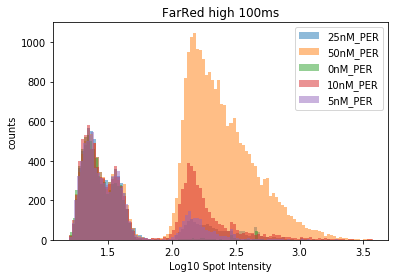

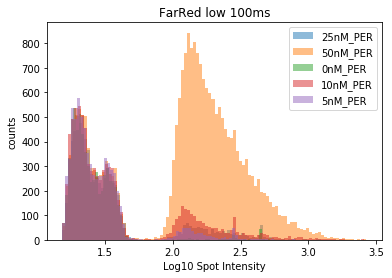

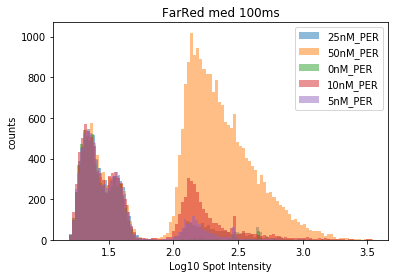

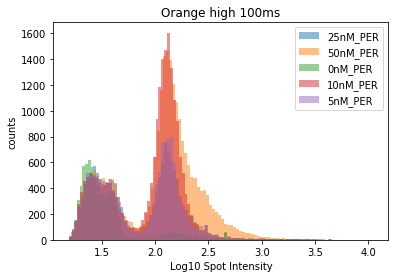

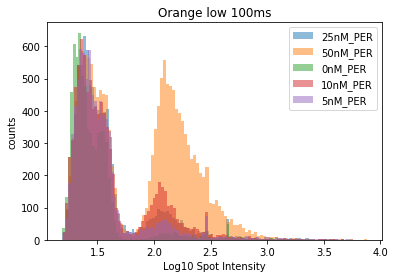

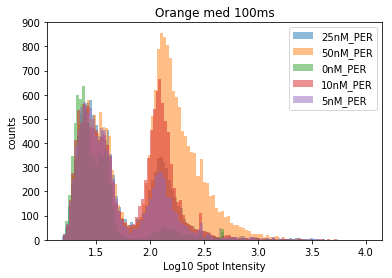

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results'
for color in os.listdir(save_path):
    color_path = os.path.join(save_path,color)
    for sigma in os.listdir(color_path):
        sigma_path = os.path.join(color_path,sigma)
        for conc in os.listdir(sigma_path):
            if not 'PER' in conc:
                continue
            conc_path = os.path.join(sigma_path,conc)
            df = pickle.load(open(os.path.join(conc_path,'df.pkl'),'rb'))
            plt.hist(np.log10(df.val),bins=100,label=conc,alpha=0.5)
        plt.title(str(color+' '+sigma+' 100ms'))
        plt.xlabel('Log10 Spot Intensity')
        plt.ylabel('counts')
        plt.legend()
        plt.show()

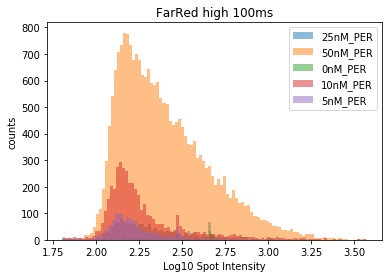

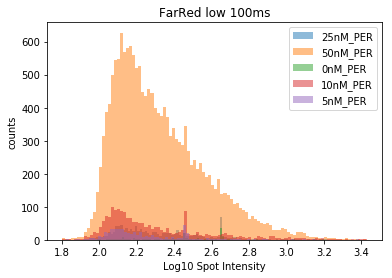

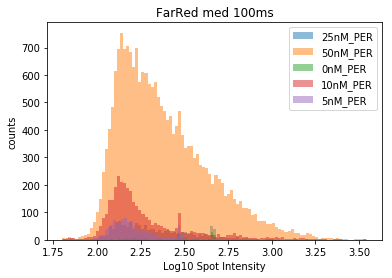

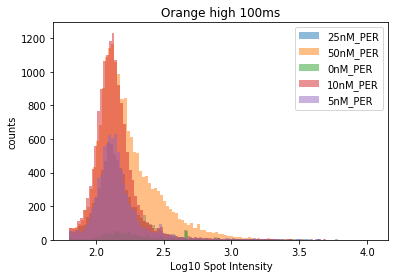

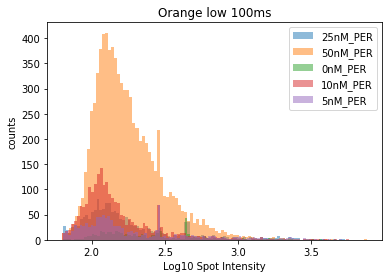

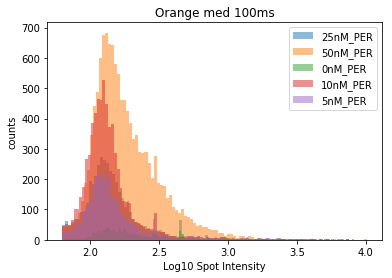

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results'
for color in os.listdir(save_path):
    color_path = os.path.join(save_path,color)
    for sigma in os.listdir(color_path):
        sigma_path = os.path.join(color_path,sigma)
        for conc in os.listdir(sigma_path):
            if not 'PER' in conc:
                continue
            conc_path = os.path.join(sigma_path,conc)
            df = pickle.load(open(os.path.join(conc_path,'good_df.pkl'),'rb'))
            plt.hist(np.log10(df.val),bins=100,label=conc,alpha=0.5)
        plt.title(str(color+' '+sigma+' 100ms'))
        plt.xlabel('Log10 Spot Intensity')
        plt.ylabel('counts')
        plt.legend()
        plt.show()

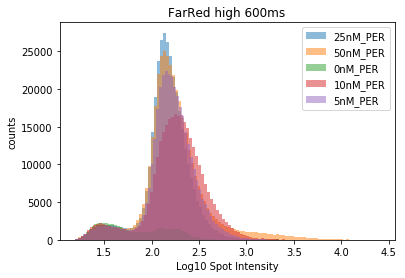

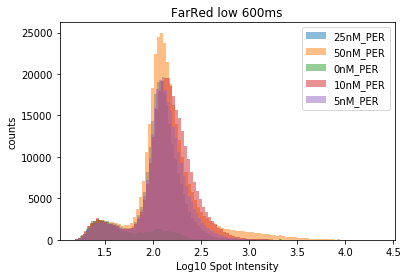

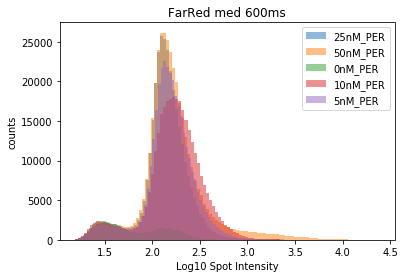

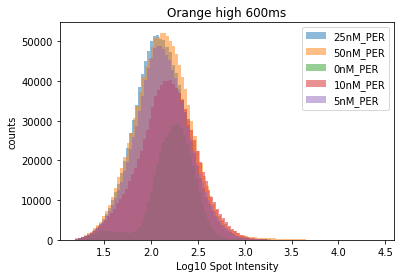

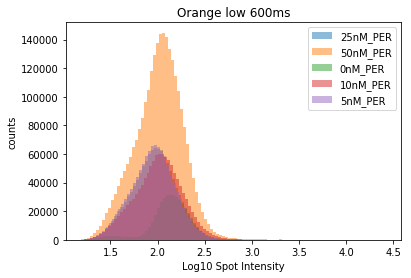

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


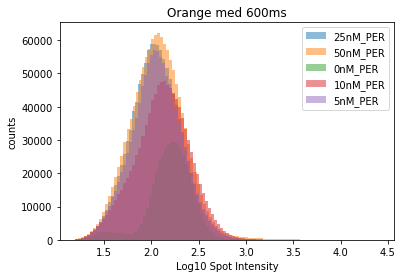

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results2'
for color in os.listdir(save_path):
    color_path = os.path.join(save_path,color)
    for sigma in os.listdir(color_path):
        sigma_path = os.path.join(color_path,sigma)
        for conc in os.listdir(sigma_path):
            if not 'PER' in conc:
                continue
            conc_path = os.path.join(sigma_path,conc)
            df = pickle.load(open(os.path.join(conc_path,'df.pkl'),'rb'))
            plt.hist(np.log10(df.val),bins=100,label=conc,alpha=0.5)
        plt.title(str(color+' '+sigma+' 600ms'))
        plt.xlabel('Log10 Spot Intensity')
        plt.ylabel('counts')
        plt.legend()
        plt.show()

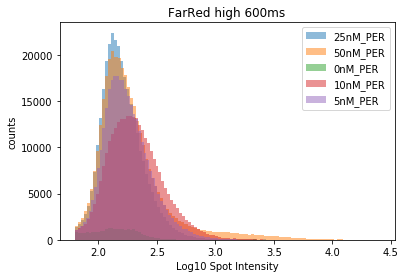

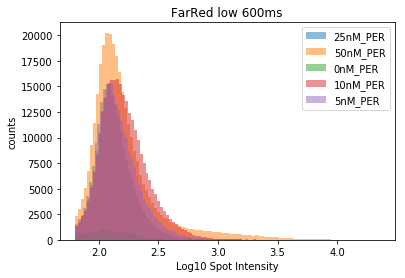

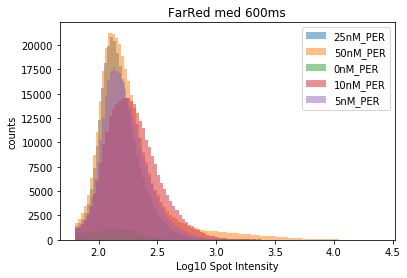

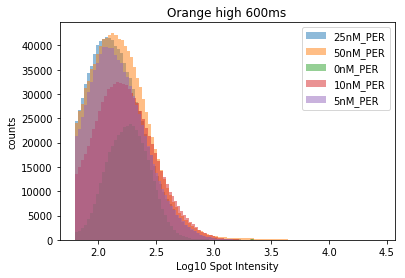

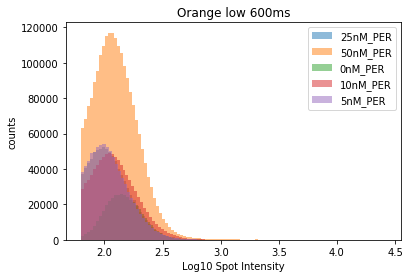

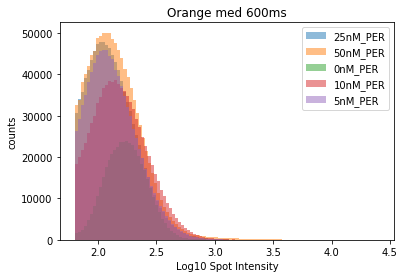

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results2'
for color in os.listdir(save_path):
    color_path = os.path.join(save_path,color)
    for sigma in os.listdir(color_path):
        sigma_path = os.path.join(color_path,sigma)
        for conc in os.listdir(sigma_path):
            if not 'PER' in conc:
                continue
            conc_path = os.path.join(sigma_path,conc)
            df = pickle.load(open(os.path.join(conc_path,'good_df.pkl'),'rb'))
            plt.hist(np.log10(df.val),bins=100,label=conc,alpha=0.5)
        plt.title(str(color+' '+sigma+' 600ms'))
        plt.xlabel('Log10 Spot Intensity')
        plt.ylabel('counts')
        plt.legend()
        plt.show()

In [23]:
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results'
conc = '50nM_PER'
color = 'Orange'
sigma = 'high'
color_path = os.path.join(save_path,color)
sigma_path = os.path.join(color_path,sigma)
conc_path = os.path.join(sigma_path,conc)
df = pickle.load(open(os.path.join(conc_path,'good_df.pkl'),'rb'))
len(df)/25

720.8

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
results = {}
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results'
for color in os.listdir(save_path):
    results[color] = {}
    color_path = os.path.join(save_path,color)
    for sigma in os.listdir(color_path):
        results[color][sigma] = {}
        sigma_path = os.path.join(color_path,sigma)
        for conc in os.listdir(sigma_path):
            if not 'PER' in conc:
                continue
            results[color][sigma][conc] = {}
            print(conc,' ',sigma,' ', color, ' 100ms')
            conc_path = os.path.join(sigma_path,conc)
            good_df = pickle.load(open(os.path.join(conc_path,'good_df.pkl'),'rb'))
            bad_df = pickle.load(open(os.path.join(conc_path,'bad_df.pkl'),'rb'))
            results[color][sigma][conc]['s/n'] = np.mean(good_df.val)/np.mean(bad_df.val)
            results[color][sigma][conc]['number'] = len(good_df)
            results[color][sigma][conc]['signal'] = np.mean(good_df.val)
            results[color][sigma][conc]['background'] = np.mean(bad_df.val)



25nM_PER   high   FarRed  100ms
50nM_PER   high   FarRed  100ms
0nM_PER   high   FarRed  100ms
10nM_PER   high   FarRed  100ms
5nM_PER   high   FarRed  100ms
25nM_PER   low   FarRed  100ms
50nM_PER   low   FarRed  100ms
0nM_PER   low   FarRed  100ms
10nM_PER   low   FarRed  100ms
5nM_PER   low   FarRed  100ms
25nM_PER   med   FarRed  100ms
50nM_PER   med   FarRed  100ms
0nM_PER   med   FarRed  100ms
10nM_PER   med   FarRed  100ms
5nM_PER   med   FarRed  100ms
25nM_PER   high   Orange  100ms
50nM_PER   high   Orange  100ms
0nM_PER   high   Orange  100ms
10nM_PER   high   Orange  100ms
5nM_PER   high   Orange  100ms
25nM_PER   low   Orange  100ms
50nM_PER   low   Orange  100ms
0nM_PER   low   Orange  100ms
10nM_PER   low   Orange  100ms
5nM_PER   low   Orange  100ms
25nM_PER   med   Orange  100ms
50nM_PER   med   Orange  100ms
0nM_PER   med   Orange  100ms
10nM_PER   med   Orange  100ms
5nM_PER   med   Orange  100ms


In [16]:
sigma_result.keys()


dict_keys(['25nM_PER', '50nM_PER', '0nM_PER', '10nM_PER', '5nM_PER'])

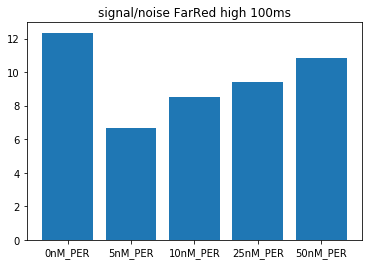

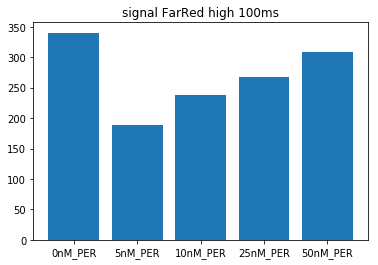

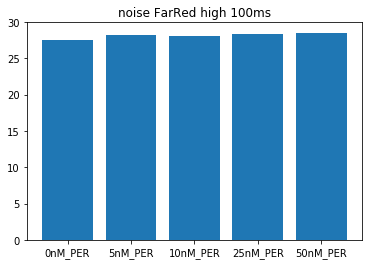

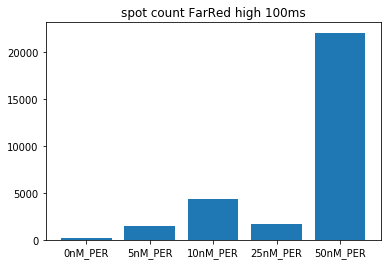

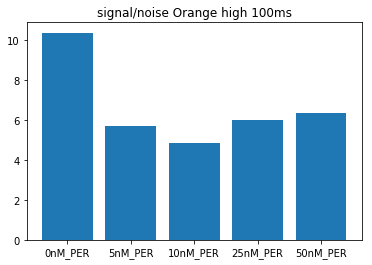

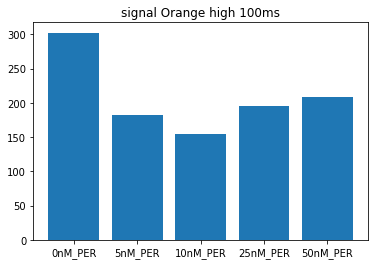

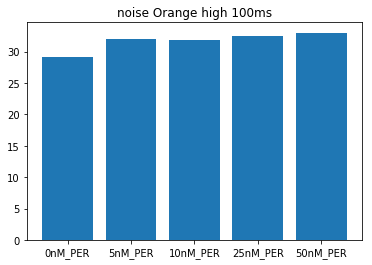

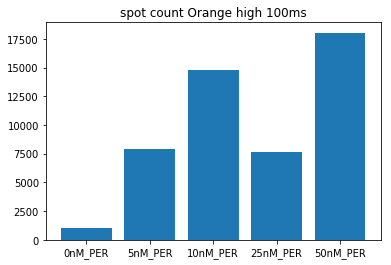

In [22]:
conc_list = ['0nM_PER','5nM_PER','10nM_PER','25nM_PER','50nM_PER',]
for color,color_result in results.items():
    for sigma,sigma_result in color_result.items():
        if not 'high' in sigma:
            continue
        SN = []
        S = []
        N = []
        num = []
        CONC = []
        for conc in conc_list:
            conc_result = sigma_result[conc]
            SN.append(conc_result['s/n'])
            S.append(conc_result['signal'])
            N.append(conc_result['background'])
            num.append(conc_result['number'])
            CONC.append(conc)
#         plt.scatter(CONC,SN)
#         plt.title('signal/noise '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.scatter(CONC,S)
#         plt.title('signal '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.scatter(CONC,N)
#         plt.title('noise '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.scatter(CONC,num)
#         plt.title('spot count '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.plot(CONC,SN)
#         plt.title('signal/noise '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.plot(CONC,S)
#         plt.title('signal '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.plot(CONC,N)
#         plt.title('noise '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.plot(CONC,num)
#         plt.title('spot count '+color+' '+sigma+' 100ms')
#         plt.show()
        plt.bar(CONC,SN)
        plt.title('signal/noise '+color+' '+sigma+' 100ms')
        plt.show()
        plt.bar(CONC,S)
        plt.title('signal '+color+' '+sigma+' 100ms')
        plt.show()
        plt.bar(CONC,N)
        plt.title('noise '+color+' '+sigma+' 100ms')
        plt.show()
        plt.bar(CONC,num)
        plt.title('spot count '+color+' '+sigma+' 100ms')
        plt.show()